In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

In [14]:
df = pd.read_csv('customers.csv')
df = df.drop(columns = df.columns[0])
df

,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40
...,...,...,...,...
195,Female,35,120,79
196,Female,45,126,28
197,Male,32,126,74
198,Male,32,137,18


In [15]:
intervals = [15, 20, 30, 40, 50, 60, 70]
df['age_range'] = pd.cut(x = df.Age, bins = intervals)
df = pd.get_dummies(df)
df = df.drop(columns = 'Age')
df

,Annual Income (k$),Spending Score (1-100),Genre_Female,Genre_Male,"age_range_(15, 20]","age_range_(20, 30]","age_range_(30, 40]","age_range_(40, 50]","age_range_(50, 60]","age_range_(60, 70]"
0,15,39,0,1,1,0,0,0,0,0
1,15,81,0,1,0,1,0,0,0,0
2,16,6,1,0,1,0,0,0,0,0
3,16,77,1,0,0,1,0,0,0,0
4,17,40,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
195,120,79,1,0,0,0,1,0,0,0
196,126,28,1,0,0,0,0,1,0,0
197,126,74,0,1,0,0,1,0,0,0
198,137,18,0,1,0,0,1,0,0,0


# Agglomerative Clustering

In [4]:
def euclid_dis(point1, point2):
    return np.sqrt(np.sum((point1 - point2)**2))

In [5]:
def init_dis(df):
    data = df.to_numpy()
    dis_mtx = np.zeros( (data.shape[0], data.shape[0]) )
    for i in range(data.shape[0]):
        for j in range(i):
            dis_mtx[i][j] = euclid_dis(data[i], data[j])
            dis_mtx[j][i] = dis_mtx[i][j]
    for i in range(data.shape[0]):
        dis_mtx[i][i] = np.inf
    return dis_mtx

In [6]:
def update_cluster_list(merge_index, cluster_list):
    cluster_list[merge_index[0]].extend(cluster_list[merge_index[1]])
    cluster_list.pop(merge_index[1])
    return cluster_list

In [7]:
def update_dis_mtx(merge_index, dis_mtx):
    dis_mtx[merge_index[0],:] = np.min(np.vstack((dis_mtx[merge_index[0],:], dis_mtx[merge_index[1],:])), axis = 0)
    dis_mtx[:,merge_index[0]] = dis_mtx[merge_index[0],:].reshape(-1)
    dis_mtx[merge_index[0], merge_index[0]] = np.inf

    dis_mtx = np.delete(dis_mtx, merge_index[1], 0)
    dis_mtx = np.delete(dis_mtx, merge_index[1], 1)
    return dis_mtx

The main function of Agglomerative Hierarchical Clustering algorithm which use all four functions above.

In [8]:
def agglo_cluster(df, n_clusters = 1):
    res = np.zeros(len(df))
    dis_mtx = init_dis(df)
    cluster_list = [[i] for i in np.arange(len(df))]
    while len(cluster_list) >= 1:
        if len(cluster_list) == n_clusters:
            for i in range(n_clusters):
                res[cluster_list[i]] = i
            return res
        merge_index = np.unravel_index(np.argmin(dis_mtx, axis=None), dis_mtx.shape)
        dis_mtx = update_dis_mtx(merge_index, dis_mtx)
        cluster_list = update_cluster_list(merge_index, cluster_list)

In comparision with the AgglomerativeClustering function of Scikit-learn

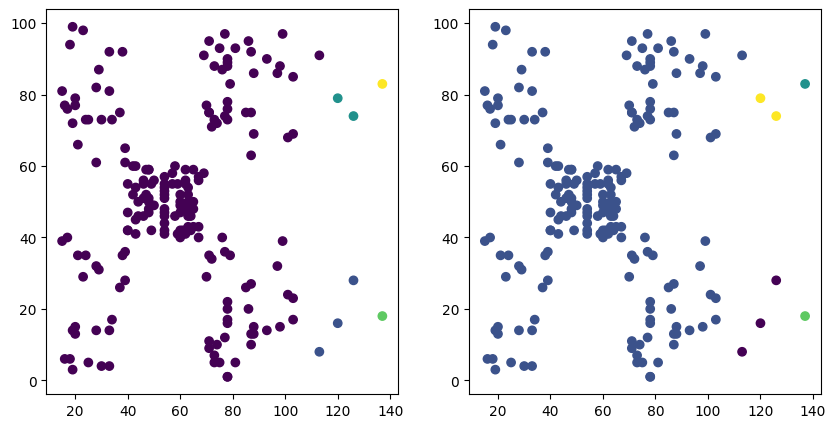

In [12]:
hand_label = agglo_cluster(df.iloc[:,[0,1]], 5)

model = AgglomerativeClustering(n_clusters = 5, linkage = 'single')
model.fit(df.iloc[:,[0,1]])
module_label = np.float64(list(model.labels_))

_, ax = plt.subplots(1,2, figsize = (10, 5))
ax[0].scatter(df.iloc[:,0],df.iloc[:,1], c = hand_label)
ax[1].scatter(df.iloc[:,0],df.iloc[:,1], c = module_label)

# Divisive Clustering

In [16]:
def euclid_dis(point1, point2):
    return np.sqrt(np.sum((point1 - point2)**2))

In [17]:
def update_cluster_list(merge_index, cluster_list):
    cluster_list[merge_index[0]].extend(cluster_list[merge_index[1]])
    cluster_list.pop(merge_index[1])
    return cluster_list

In [18]:
def MST(df):
    data = df.to_numpy()
    cluster_list = []
    tree_mtx = np.array([[-1.0]*data.shape[0] for i in range(data.shape[0])])
    dis_list = []
    point_list = []
    edge_list = []
    indices = 0

    for i in range(len(df)):
        for j in range(i):
          dis_list.append([[i, j], euclid_dis(data[i],data[j])])
    ord_dis_list = pd.DataFrame(dis_list).sort_values(by = 1).values.tolist()

    while len(edge_list) + 1 < len(df):
        point1, point2 = ord_dis_list[indices][0]

        if point1 not in point_list or point2 not in point_list:

            if point1 in point_list:
                cluster_index = [i for i in range(len(cluster_list)) if point1 in cluster_list[i]][0]
                cluster_list[cluster_index].append(point2)

            if point2 in point_list:
                cluster_index = [i for i in range(len(cluster_list)) if point2 in cluster_list[i]][0]
                cluster_list[cluster_index].append(point1)

            if point1 not in point_list and point2 not in point_list:
                cluster_list.append([point1, point2])

            point_list.append(point1)
            point_list.append(point2)
            edge_list.append(ord_dis_list[indices])
        else:
            check = [point2 in cluster for cluster in cluster_list if point1 in cluster]

            if (np.sum(check) == 0):
                edge_list.append(ord_dis_list[indices])

                cluster1_index = [i for i in range(len(cluster_list)) if point1 in cluster_list[i]][0]
                cluster2_index = [i for i in range(len(cluster_list)) if point2 in cluster_list[i]][0]

                merge_index = (cluster1_index, cluster2_index)
                cluster_list = update_cluster_list(merge_index, cluster_list)
        indices += 1

    for edge in edge_list:
        point1, point2 = edge[0]
        tree_mtx[point1, point2] = tree_mtx[point2, point1] = edge[1]
    return tree_mtx

In [19]:
def cluster_trace(point, tree_mtx, cluster):
    cluster.append(point)
    for i in range(len(tree_mtx)):
        if tree_mtx[point, i] != -1:
            tree_mtx[point, i] = tree_mtx[i, point] = -1
            cluster_trace(i, tree_mtx, cluster)
    return cluster

In [20]:
def divisive_cluster(df, n_clusters = 1):
    tree_mtx = MST(df)
    cluster_list = []
    cluster_point = []
    for i in range(n_clusters - 1):
        maxdis_index = np.unravel_index(np.argmax(tree_mtx, axis=None), tree_mtx.shape)
        tree_mtx[maxdis_index[0], maxdis_index[1]] = -1
        tree_mtx[maxdis_index[1], maxdis_index[0]] = -1
        cluster_point.append(maxdis_index[0])
        cluster_point.append(maxdis_index[1])

    cluster_point = np.unique(cluster_point)
    for point in cluster_point:
        check = [point in cluster for cluster in cluster_list]
        if (np.sum(check) == 0):
            cluster = []
            cluster = cluster_trace(point,tree_mtx, cluster)
            cluster_list.append(cluster)

    res = np.zeros(len(df))
    for i in range(n_clusters):
        res[cluster_list[i]] = i
    return res

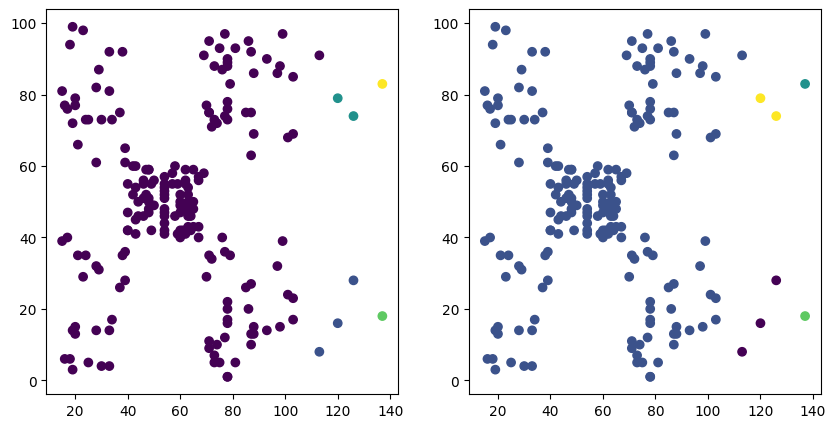

In [26]:
hand_label = divisive_cluster(df.iloc[:,[0,1]], 5)

model = AgglomerativeClustering(n_clusters = 5, linkage = 'single')
model.fit(df.iloc[:,[0,1]])
module_label = np.float64(list(model.labels_))

_, ax = plt.subplots(1,2, figsize = (10, 5))
ax[0].scatter(df.iloc[:,0],df.iloc[:,1], c = hand_label)
ax[1].scatter(df.iloc[:,0],df.iloc[:,1], c = module_label)